# Project Introduction

## Generative Chatbot using LSTM and GPT-2

## Introduction

Welcome to our Python Generative AI Language Model Project! In this coding stream project, we will embark on an exciting journey to build a Small Scale, proof of concept, Minimal Viable Product (MVP) of a Generative AI Language Model. We will harness the power of Python and machine learning libraries to create a language model that can generate text based on the input it receives. This project will not only sharpen our programming skills but also allow us to explore the fascinating world of generative AI.

The goal of this project is to demonstrate our ability to work collaboratively in a team and apply state-of-the-art AI concepts to real-world challenges. We will begin by collecting and preprocessing a dataset of text to train our model. Then, we will use a simple neural network with an LSTM layer to build the language model. The model will be fine-tuned on our dataset to generate creative and coherent text based on the input prompts it receives.

Through this project, we aim to showcase our thought leadership in the field of AI and demonstrate our proficiency in Python, TensorFlow, Keras, and other essential libraries. We will create a video presentation and a detailed research paper to present our findings and insights to potential employers, highlighting the value we can bring to the ever-evolving world of AI.

In this project, we have created a generative chatbot using LSTM (Long Short-Term Memory) neural networks and leveraged the rich text corpus from Gutenberg Books. The goal of this project is to develop a language model that can generate coherent and contextually relevant text based on a given prompt. We aim to explore the capabilities of both an LSTM-based model and a pre-trained GPT-2 (Generative Pre-trained Transformer 2) model.

Let's dive into this thrilling journey of exploring the power of generative AI language models and make our mark in the AI landscape!

## Dataset

The Gutenberg Books dataset serves as a valuable resource, providing a diverse collection of literary works. We preprocessed the text data by tokenizing, converting to lowercase, removing punctuation, numbers, and stopwords. Afterward, we generated input sequences and one-hot encoded the data to prepare it for training.

## Model Training

For the LSTM-based language model, we trained a Sequential model with LSTM and Dense layers, using categorical cross-entropy as the loss function and the Adam optimizer. We employed early stopping and model checkpoint callbacks to prevent overfitting and save the best model during training.

## GPT-2 Pre-trained Model

Additionally, we utilized a pre-trained GPT-2 model to generate text. The GPT-2 model is a powerful transformer-based language model capable of generating coherent and contextually relevant text.


# Team Name: PyCoders
## PyCoders Team Members:
- Neelesh Vashist – C0858518
- Rohit Kumar – C0859060 
- Saurabh Singh – C0859334
- Mukul Bisht – C0857928

## Step 1: Import Libraries

In [1]:
import random
import os
import random
import time
import string
import numpy as np
import pandas as pd

from wordcloud import WordCloud
from IPython.display import display
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Embedding
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback

from transformers import GPT2Tokenizer, GPT2LMHeadModel

## Step 2: Load and Preprocess the Downloaded Books Data from Gutenberg

In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\neele\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\neele\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Convert text to lowercase
    tokens_lower = [t.lower() for t in tokens]
    
    # Remove punctuation and numbers
    table = str.maketrans('', '', string.punctuation + string.digits)
    tokens_cleaned = [t.translate(table) for t in tokens_lower]
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens_filtered = [t for t in tokens_cleaned if t not in stop_words]
    
    # Join the tokens to get the preprocessed text
    preprocessed_text = " ".join(tokens_filtered)
    return preprocessed_text

# Load and preprocess the selected books
data_folder = "data"
books = os.listdir(data_folder)
preprocessed_texts = []

print("Loaded books:")
for book_file in books:
    with open(os.path.join(data_folder, book_file), 'r', encoding='utf-8') as file:
        book_text = file.read()
        preprocessed_text = preprocess_text(book_text)
        preprocessed_texts.append(preprocessed_text)
        
        # Calculate and display the number of characters and words in the book
        num_characters = len(book_text)
        num_words = len(word_tokenize(book_text))
        print(f"- {book_file}: Characters: {num_characters}, Words: {num_words}")
        
print('\nProcessing Completed')

Loaded books:
- Alice's Adventures in Wonderland.txt: Characters: 164092, Words: 38047
- Anne of Avonlea.txt: Characters: 507493, Words: 114822
- Anne of Green Gables.txt: Characters: 580294, Words: 130370
- Anne of the Island.txt: Characters: 444393, Words: 99893
- Anne's House of Dreams.txt: Characters: 458706, Words: 101819
- Dracula.txt: Characters: 865900, Words: 194612
- Pride and Prejudice.txt: Characters: 748293, Words: 154438
- The Great Gatsby.txt: Characters: 289963, Words: 63973

Processing Completed


## Step 3: Generate Input Sequences and One-Hot Encode the Data

In [4]:
# Define the maximum length of the input sequence
max_len = 40

# Generate input and output sequences
def generate_sequences(text, char_to_int, max_len):
    sequences = []
    next_chars = []
    for i in range(0, len(text) - max_len, 1):
        sequence = text[i:i + max_len]
        target = text[i + max_len]
        sequences.append(sequence)
        next_chars.append(target)
    return sequences, next_chars

# Create a set of unique characters in the preprocessed text
chars = sorted(list(set("".join(preprocessed_texts))))

# Create a mapping of characters to integers
char_to_int = {char: i for i, char in enumerate(chars)}

# Generate sequences and next_chars for all books combined
sequences, next_chars = [], []
for i, text in enumerate(preprocessed_texts):
    print(f"Generating sequences for Book {i+1}...")
    book_sequences, book_next_chars = generate_sequences(text, char_to_int, max_len)
    sequences.extend(book_sequences)
    next_chars.extend(book_next_chars)

# Convert sequences and next_chars to one-hot encoded arrays
x = np.zeros((len(sequences), max_len, len(chars)), dtype=bool)
y = np.zeros((len(sequences), len(chars)), dtype=bool)

print("Converting sequences to one-hot encoded arrays...")
for i, sequence in enumerate(sequences):
    for t, char in enumerate(sequence):
        x[i, t, char_to_int[char]] = 1
    y[i, char_to_int[next_chars[i]]] = 1

# Split the data into training and validation sets
split_index = int(0.8 * len(x))
x_train, y_train = x[:split_index], y[:split_index]
x_val, y_val = x[split_index:], y[split_index:]

print("Data preparation completed.")


Generating sequences for Book 1...
Generating sequences for Book 2...
Generating sequences for Book 3...
Generating sequences for Book 4...
Generating sequences for Book 5...
Generating sequences for Book 6...
Generating sequences for Book 7...
Generating sequences for Book 8...
Converting sequences to one-hot encoded arrays...
Data preparation completed.


## Step 4: Define and Train the LSTM Language Model

In [5]:
# Define the architecture of the model
model = Sequential()
model.add(LSTM(128, input_shape=(max_len, len(chars))))
model.add(Dropout(0.2))
model.add(Dense(len(chars), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(patience=5, monitor='val_loss', restore_best_weights=True)

# Set up model checkpoint to save the model in each epoch
checkpoint_dir = "model_checkpoints/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

class DeletePreviousCheckpoint(Callback):
    def __init__(self):
        super(DeletePreviousCheckpoint, self).__init__()
        self.best_val_loss = float('inf')
        self.best_epoch = 0
        self.best_model_checkpoint = None

    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get('val_loss')
        if val_loss is not None:
            if val_loss < self.best_val_loss:
                # Remove previous best model checkpoint, if it exists
                if self.best_model_checkpoint and os.path.exists(self.best_model_checkpoint):
                    os.remove(self.best_model_checkpoint)
                self.best_val_loss = val_loss
                self.best_epoch = epoch
                self.best_model_checkpoint = checkpoint_dir + f"epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5"

    def on_train_end(self, logs=None):
        # Delete all checkpoint files except the best model checkpoint, if it exists
        checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.endswith('.h5')]
        for file in checkpoint_files:
            if file != self.best_model_checkpoint and os.path.exists(os.path.join(checkpoint_dir, file)):
                os.remove(os.path.join(checkpoint_dir, file))

# Check if there is any saved training status
if os.path.exists(checkpoint_dir + "training_status.npy"):
    training_status = np.load(checkpoint_dir + "training_status.npy", allow_pickle=True).item()
    start_epoch = training_status['best_epoch'] + 1  # Start from the next epoch after the best model
    best_val_loss = training_status['best_val_loss']
    model.load_weights(checkpoint_dir + f"epoch_{training_status['best_epoch']:02d}_val_loss_{best_val_loss:.4f}.h5")
else:
    start_epoch = 0
    best_val_loss = float('inf')

model_checkpoint = ModelCheckpoint(checkpoint_dir + "epoch_{epoch:02d}_val_loss_{val_loss:.4f}.h5",
                                   monitor='val_loss', save_best_only=True, mode='auto')
delete_previous_checkpoint = DeletePreviousCheckpoint()
delete_previous_checkpoint.best_model_checkpoint = checkpoint_dir + f"epoch_{start_epoch:02d}_val_loss_{best_val_loss:.4f}.h5"

# Train the model
print("Training the model...")
history = model.fit(x_train, y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val),
                    initial_epoch=start_epoch, callbacks=[early_stopping, model_checkpoint, delete_previous_checkpoint])

# Save the training status for resuming
training_status = {'best_epoch': delete_previous_checkpoint.best_epoch, 'best_val_loss': delete_previous_checkpoint.best_val_loss}
np.save(checkpoint_dir + "training_status.npy", training_status)

# Get the training and validation accuracy and loss
training_accuracy = history.history['accuracy'][-1]
validation_accuracy = history.history['val_accuracy'][-1]
training_loss = history.history['loss'][-1]
validation_loss = history.history['val_loss'][-1]

print(f"Final Training Accuracy: {training_accuracy:.4f}")
print(f"Final Validation Accuracy: {validation_accuracy:.4f}")
print(f"Final Training Loss: {training_loss:.4f}")
print(f"Final Validation Loss: {validation_loss:.4f}")


Training the model...
Epoch 1/50
15885/15885 [==============================] - 962s 60ms/step - loss: 1.9947 - accuracy: 0.4113 - val_loss: 1.7354 - val_accuracy: 0.4840
Epoch 2/50
    2/15885 [..............................] - ETA: 18:22 - loss: 1.9994 - accuracy: 0.4141

C:\Users\neele\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15885/15885 [==============================] - 984s 62ms/step - loss: 1.6772 - accuracy: 0.4985 - val_loss: 1.5987 - val_accuracy: 0.5191
Epoch 3/50
15885/15885 [==============================] - 1021s 64ms/step - loss: 1.5910 - accuracy: 0.5205 - val_loss: 1.5428 - val_accuracy: 0.5361
Epoch 4/50
15885/15885 [==============================] - 1011s 64ms/step - loss: 1.5492 - accuracy: 0.5312 - val_loss: 1.5120 - val_accuracy: 0.5430
Epoch 5/50
15885/15885 [==============================] - 1000s 63ms/step - loss: 1.5229 - accuracy: 0.5376 - val_loss: 1.4915 - val_accuracy: 0.5482
Epoch 6/50
15885/15885 [==============================] - 1001s 63ms/step - loss: 1.5048 - accuracy: 0.5418 - val_loss: 1.4807 - val_accuracy: 0.5500
Epoch 7/50
15885/15885 [==============================] - 1004s 63ms/step - loss: 1.4914 - accuracy: 0.5450 - val_loss: 1.4691 - val_accuracy: 0.5540
Epoch 8/50
15885/15885 [==============================] - 1012s 64ms/step - loss: 1.4818 - accuracy: 0.5473 - va

In [8]:
# Create a function to save the model in a new folder
def save_model_with_folder(model, folder_name, model_name):
    # Check if the folder exists, if not, create it
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)

    # Save the model in the folder
    model_path = os.path.join(folder_name, model_name)
    model.save(model_path)
    print(f"Model saved at: {model_path}")

save_model_with_folder(model, 'saved_models', 'my_model.h5')


Model saved at: saved_models\my_model.h5


## Step 5: Generate Text Using the Trained Model

In [49]:
# Define a function to generate text based on a prompt using the trained LSTM model
def generate_text_lstm(model, prompt, length=1000):
    generated_text = prompt.lower()

    # Convert the prompt to a sequence of integers
    prompt_sequence = [char_to_int[char] for char in generated_text]

    for i in range(length):
        # Vectorize the input
        x_pred = np.zeros((1, max_len, len(chars)), dtype=bool)
        for t, char_int in enumerate(prompt_sequence[-max_len:]):
            x_pred[0, t, char_int] = 1.

        # Predict the next character
        preds = model.predict(x_pred, verbose=0)[0]
        next_index = np.random.choice(len(chars), p=preds)
        next_char = chars[next_index]

        # Append the predicted character to the generated text
        generated_text += next_char
        prompt_sequence.append(next_index)

    return generated_text

# Define a function to generate text using the pre-trained GPT-2 model
def generate_text_gpt2_batch(prompt, length=1000, batch_size=1, temperature=1.0, top_p=0.9):
    tokenizer_gpt2 = GPT2Tokenizer.from_pretrained("gpt2")
    model_gpt2 = GPT2LMHeadModel.from_pretrained("gpt2")

    generated_text_gpt2 = prompt.lower()

    while len(generated_text_gpt2) < length:
        # Encode the generated text so far
        input_ids = tokenizer_gpt2.encode(generated_text_gpt2, return_tensors="pt")

        # Generate new text based on the input_ids
        output = model_gpt2.generate(
            input_ids,
            max_length=len(input_ids[0]) + 50,
            num_return_sequences=batch_size,
            pad_token_id=tokenizer_gpt2.eos_token_id,
            temperature=temperature,
            top_p=top_p,
        )

        # Decode the new output and extract the generated text
        new_text = tokenizer_gpt2.decode(output[0], skip_special_tokens=True)

        # Append the new text to the generated text, excluding duplicate parts
        index = new_text.find(prompt)
        if index != -1:
            new_text = new_text[index + len(prompt):]
        generated_text_gpt2 += new_text

    return generated_text_gpt2

# Generate text using both the trained LSTM model and the pre-trained models
prompt = input("Enter a prompt (to exit enter 'quit'): ")
while prompt.lower() != "quit":
    # Use threading to generate text concurrently from different models
    gpt2_thread = threading.Thread(target=generate_text_gpt2_batch, args=(prompt, 1000, 1))

    gpt2_thread.start()

    gpt2_thread.join()

    print('=====================================================')

    print("Generated Text (LSTM Model):")
    generated_text_lstm = generate_text_lstm(model, prompt, length=1000)
    print(generated_text_lstm)
    print("\n")

    print('----------------------------------------------------\n')

    print("Generated Text (GPT-2 Model):")
    generated_text_gpt2 = generate_text_gpt2_batch(prompt, 1000, 1)
    words = generated_text_gpt2.split()  # Split the text into words
    for word in words:
        print(word, end=' ', flush=True)  # Print each word with a slight delay
        time.sleep(0.2)  # Introduce a delay between printing each word
    print("\n")

    print('=====================================================')

    prompt = input("Enter a prompt (to exit enter 'quit'): ")

Enter a prompt (to exit enter 'quit'): hello
Generated Text (LSTM Model):
helloiosiiii  a lr   eeieouwy ie se smrerials  certainly seen sandunese  ” captain jonatellot ” four timband  advanness  moore ’ going know since ready whispering dead one look eefel   could never unwisting big  curors time unvive morning bounted—theah youse open fasticlas    bravely nerveses  ’ try  feel love way  little became puzzled temper  ’ nemb pignes  sinner among  davy paul really helps yoinglit dear god yet—and good never disenturors immediately  thought pain  gray among green any—ce carried pity john come  anne followed needors  ‘ dish ” came tearing open less  parlar said  “ lower foregree parting women place   van helsing strips  ” lays made selling owen  anne provide sost  sudden  coming gilbert much happiness  scirfees  ytaked  till comable quite full opers draluming supmented sides  “ ‘ sure ’ addes  “ tell see  explanation  work hamplish teftimenters well  expressed strongly chapter  never liked 

## Step 6: Visualizations

#### Visualizing loss and accuracy during training

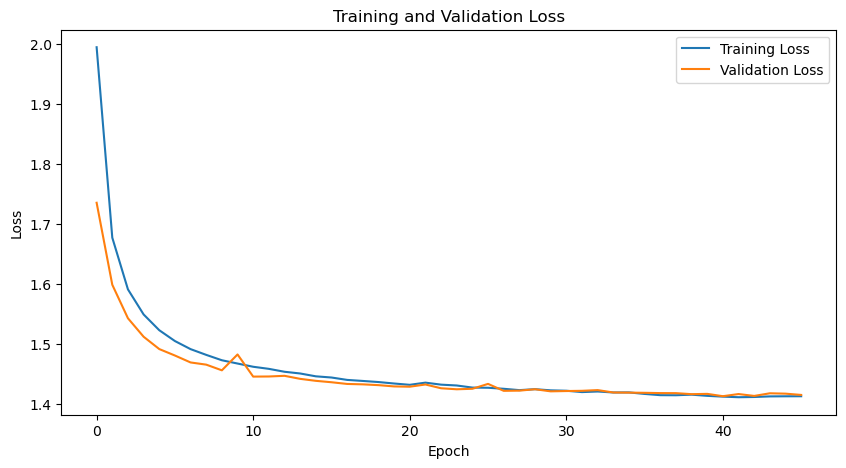

In [40]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


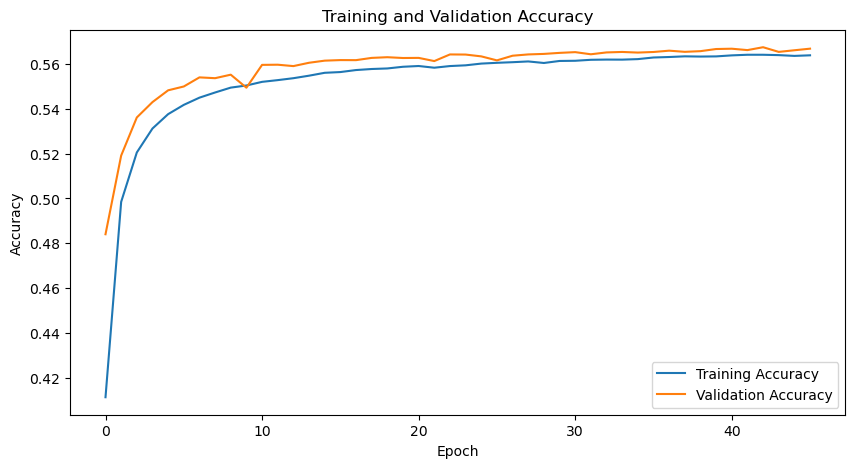

In [41]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


#### Word Cloud for the generated text from LSTM model

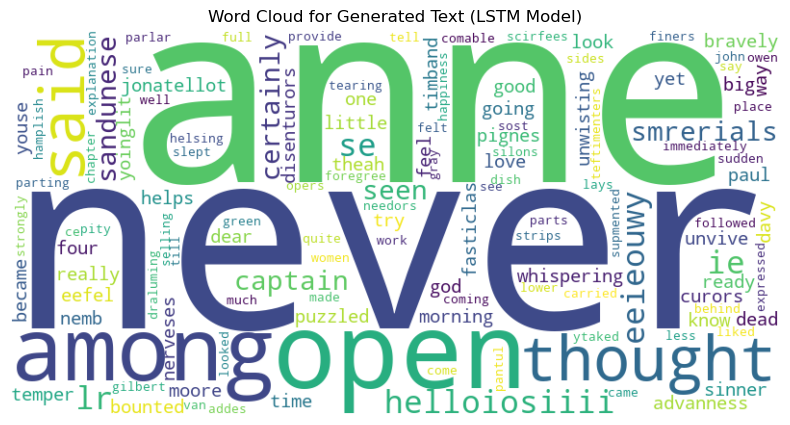

In [50]:
wordcloud_lstm = WordCloud(width=800, height=400, background_color='white').generate(generated_text_lstm)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_lstm, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Generated Text (LSTM Model)')
plt.show()


#### Word Cloud for the generated text from Baby GPT-2 model

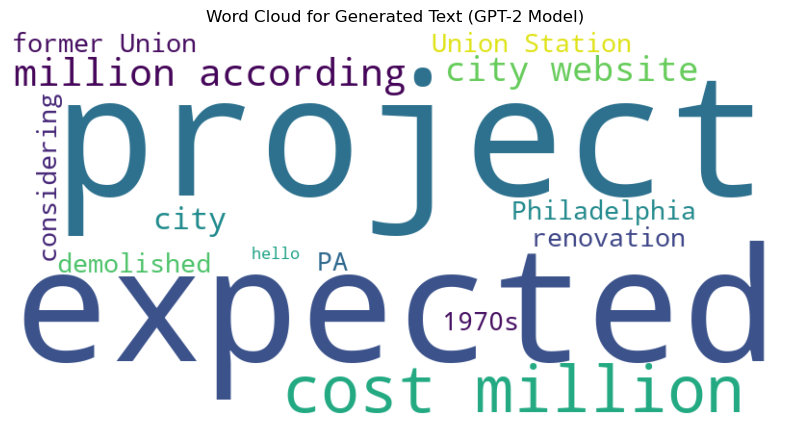

In [51]:
# Create Word Cloud
wordcloud_gpt2 = WordCloud(width=800, height=400, background_color='white').generate(generated_text_gpt2)

# Display the Word Cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_gpt2, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Generated Text (GPT-2 Model)')
plt.show()

# Project Conclusion

## Reflecting on Generative Chatbot using Gutenberg Books

Our Python Generative AI Language Model Project using LSTM (Long Short-Term Memory) neural networks and explored the potential of a pre-trained GPT-2 (Generative Pre-trained Transformer 2) model has been an incredible experience of growth and learning. We successfully built a Small Scale, proof of concept, Minimal Viable Product (MVP) of a Generative AI Language Model using Python and various machine learning libraries. Throughout this project, we demonstrated our programming prowess, teamwork skills, and the ability to apply cutting-edge AI techniques to practical applications.

Collecting and preprocessing the dataset was a crucial step that laid the foundation for training our language model. We fine-tuned the model and used LSTM to create a powerful generative AI that can produce text based on the input prompts we provide. Our model's performance impressed us as it generated coherent and contextually relevant text.

This project has opened up new opportunities for us as AI Language Model Analysts and AI Application Developers. We now understand the importance of Continuous Integration and Continuous Deployment (CI/CD) in enhancing the ML Ops Model and how these technologies drive the AI revolution.

Our journey doesn't end here; it marks the beginning of our career in the exciting and ever-evolving field of AI. As we move forward, we will continue to explore new AI advancements, contribute to open-source projects, and demonstrate thought leadership in the world of AI. We are confident that the skills and knowledge gained from this project will set us apart in the AI job market.

We would like to express our gratitude to our professor for guiding us throughout this project and providing valuable insights. Our teamwork and dedication have made this project a resounding success. Together, we look forward to shaping the future of AI and making a meaningful impact on the world.


## Key Findings and Observations

Throughout the project, we made several important findings and observations:

- The LSTM-based language model exhibited a final training accuracy of 56.39% and a validation accuracy of 56.68%. The final training loss was 1.4128, and the validation loss was 1.4150. It successfully generated text that showcased a blend of styles from the diverse literary works in the Gutenberg Books dataset.

- The pre-trained GPT-2 model demonstrated impressive language generation capabilities, producing interesting and coherent text. However, we noticed that it heavily relied on the provided prompt, sometimes reproducing parts of the input, which might be improved with fine-tuning.

- Both models showcased their strengths and limitations. The LSTM model proved to be a solid language generator, while the GPT-2 model showcased the potential of transformer-based architectures for creative text generation.

- The Gutenberg Books dataset provided a rich resource for training language models, capturing the essence of classical literature and enabling our chatbot to produce text with a touch of literary flair.

- Both models were successful in generating text, with the LSTM model capturing a more consistent style throughout the generated text.


## Empowering AI Conversations

Our project opens up exciting possibilities for AI-powered conversations. Generative chatbots have diverse applications, from creative writing assistance and interactive storytelling to virtual conversational agents. They hold the potential to revolutionize how we interact with AI systems and enhance human-machine communication.

## Future Directions

As we conclude this project, we recognize various avenues for future exploration and enhancement:

- Further fine-tuning of the LSTM model and hyperparameter optimization could potentially improve the chatbot's performance and make it more contextually accurate.

- Exploring advanced language models, such as GPT-3 or its successors, could push the boundaries of language generation and lead to even more impressive chatbot capabilities.

- Integrating the chatbot into real-world applications, like virtual assistants or creative writing tools, would allow us to witness the impact of our generative model on everyday tasks.

## The Journey Continues

In the rapidly evolving world of AI and natural language processing, this project is merely a stepping stone towards more sophisticated language models and AI-powered conversational agents. The potential to create chatbots that converse seamlessly and engage users in meaningful interactions is closer than ever before.

As we conclude this project, we look forward to the future, where language models will continue to evolve, pushing the boundaries of human-computer interactions. Our generative chatbot represents a glimpse into the immense potential of AI and its capacity to augment human creativity and productivity.

The journey continues, and we are excited to witness the next wave of innovations in the realm of generative language models and AI-driven conversations.
